In [5]:
.libPaths("/home/groups/candes/Software/miniconda2/envs/ukb/lib/R/library")
suppressMessages(library(tidyverse))
suppressMessages(library(superheat))
suppressMessages(library(qqman))
suppressMessages(library(ggrepel))

source("utils_clumping.R")

scratch <- "/scratch/PI/candes/ukbiobank_tmp"

## Load discoveries

In [2]:
resolution <- "Radj2"
phenotype.list <- c("height","bmi","sbp","platelet",
                    "cvd","diabetes","hypothyroidism","respiratory","glaucoma")

Discoveries <- lapply(phenotype.list, function(phenotype) {
    # Load LMM discoveries (if available)
    lmm.file <- sprintf("%s/discoveries/%s_lmm_regions.txt", scratch, phenotype)
    if(file.exists(lmm.file)) {
        Discoveries.LMM <- read_delim(lmm.file, delim=" ", col_types=cols()) %>%
            mutate(Phenotype=phenotype, Method="LMM", Importance=-log10(P), Resolution="GWAS") %>%
            select(-c("P"))
        #cat(sprintf("Found %d discoveries for %s made with LMM.\n", nrow(Discoveries.LMM), phenotype))
    } else {
        cat(sprintf("Discoveries for %s made with LMM are not available.\n", phenotype))
        Discoveries.LMM <- tibble()
    }
    
    # Load knockoffs discoveries (if available)
    knockoffs.file <- sprintf("%s/discoveries/%s_knockoffs_%s.txt", scratch, phenotype, resolution)
    if(file.exists(knockoffs.file)) {
        Discoveries.knockoffs <- read_delim(knockoffs.file, delim=" ", col_types=cols()) %>%
            mutate(Phenotype=phenotype, Method="Knockoffs", Importance=W, Resolution=resolution) %>%
            select(-c("W", "Group"))
        #cat(sprintf("Found %d discoveries for %s made with knockoffs at resolution %s.\n", 
        #            nrow(Discoveries.knockoffs), phenotype, resolution))
    } else {
        cat(sprintf("Discoveries for %s made with knockoffs at resolution %s are not available.\n", 
            phenotype, resolution))
        Discoveries.knockoffs <- tibble()
    }
    
    # Combine results
    return(rbind(Discoveries.LMM,Discoveries.knockoffs))
})
Discoveries <- do.call("rbind", Discoveries)

## Clumped discoveries

In [10]:
Discoveries.consolidated <- Discoveries %>% 
    group_by(Phenotype, Method, Resolution) %>%
    consolidate_clumps()

Summary.consolidated <- Discoveries.consolidated %>% 
    group_by(Phenotype, Method, Resolution) %>%
    summarise(N=n()) %>% 
    ungroup() %>% select(-Resolution) %>%
    spread(key = Method, value = N) %>%
    replace_na(list(Knockoffs=0, LMM=0))

Summary.consolidated

Phenotype,Knockoffs,LMM
bmi,1304,328
cvd,417,136
diabetes,47,42
glaucoma,0,1
height,1702,795
hypothyroidism,149,77
platelet,1062,428
respiratory,164,47
sbp,641,178


In [8]:
Summary <- Discoveries %>% 
    group_by(Phenotype, Method, Resolution) %>%
    summarise(N=n()) %>% 
    ungroup() %>% select(-Resolution) %>%
    spread(key = Method, value = N) %>%
    replace_na(list(Knockoffs=0, LMM=0))

Summary

Phenotype,Knockoffs,LMM
bmi,1808,389
cvd,475,156
diabetes,48,47
glaucoma,0,1
height,3252,1685
hypothyroidism,163,96
platelet,1479,723
respiratory,183,63
sbp,745,197


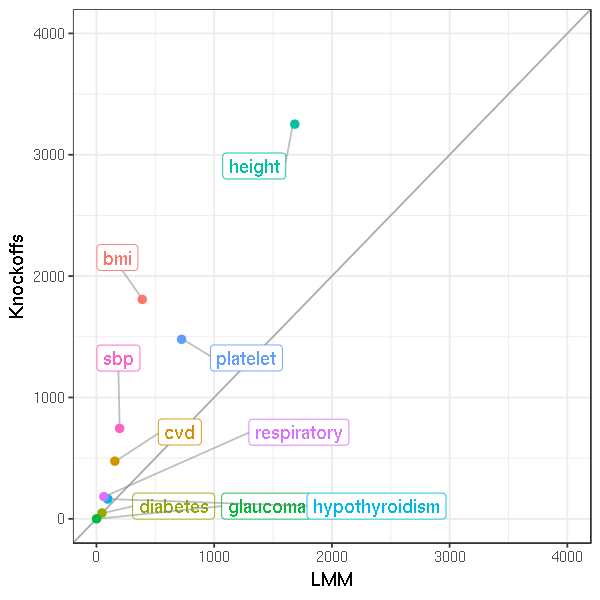

In [26]:
options(repr.plot.width=5, repr.plot.height=5)

xy.lim <- max(max(Summary$Knockoffs,na.rm=T), max(Summary$LMM,na.rm=T))
xy.lim <- ceiling(xy.lim/1000)*1000

Summary %>%
    ggplot(aes(x=LMM, y=Knockoffs, color=Phenotype)) +
    geom_abline(color="darkgrey") +
    geom_label_repel(aes(label = Phenotype),
                  box.padding   = 1, 
                  point.padding = 0.2,
                  segment.color = 'grey50',
                  segment.alpha = 0.5) +
    geom_point(size=2) + 
    scale_x_continuous(trans='identity', limits=c(0,xy.lim)) +
    scale_y_continuous(trans='identity', limits=c(0,xy.lim)) +
    theme_bw() + theme(legend.position="none")

summary.file <- sprintf("figures/summary_ndiscoveries.png")
ggsave(summary.file, width=5, height=5)

Phenotype,Knockoffs,LMM
bmi,0.3063005,0.6162520
cvd,0.3133190,0.4746735
diabetes,0.2989195,0.3217250
glaucoma,NA,0.1512850
height,0.2543695,0.4693380
hypothyroidism,0.2267500,0.3612850
platelet,0.2549800,0.4956820
respiratory,0.2485500,0.4676550
sbp,0.2870410,0.3994010


Warning message:
“Removed 1 rows containing missing values (geom_label_repel).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_label_repel).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

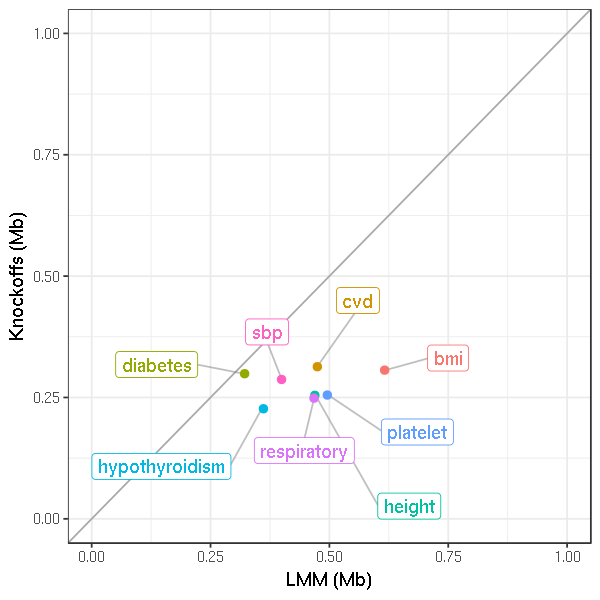

In [27]:
Summary.resolution <- Discoveries %>% 
    group_by(Phenotype, Method, Resolution) %>%
    summarise(BP.width=median(BP.width), BP.width=BP.width/1e6) %>% 
    ungroup() %>% select(-Resolution) %>%
    spread(key = Method, value = BP.width)

Summary.resolution

Summary.resolution %>%
    ggplot(aes(x=LMM, y=Knockoffs, color=Phenotype)) +
    geom_abline(color="darkgrey") +
    geom_label_repel(aes(label = Phenotype),
                  box.padding   = 1, 
                  point.padding = 0.2,
                  segment.color = 'grey50',
                  segment.alpha = 0.5) +
    geom_point(size=2) + 
    xlim(0,1) + ylim(0,1) +
    xlab("LMM (Mb)") + ylab("Knockoffs (Mb)") +
    theme_bw() + theme(legend.position="none")

summary.file <- sprintf("figures/summary_resolution.png")
ggsave(summary.file, width=5, height=5)